# Exploratory Notebook for the Erythemal Irradiance Data
Load the dataset and find average daily irradinace across different locations. Use anomaly detection to find potentially erroneous data entries.

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
import sqlite3

import numpy as np
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from uv_monitor.logging import logger
from uv_monitor.dataio import parse_header, read_csv_file, read_folder
from uv_monitor.anomaly import DailyAnomalyDetector
from uv_monitor.utils import plot_anomaly

In [12]:
df, header = read_csv_file("../data/Ontario-Toronto-2022-ery.csv")
print(header)
df.head(5)

#Erythemal Radiation is the irradiance in Watts per square meter measured over the 300 through 400 nanometer range and weighted with the Mc Kinlay and Diffey, (1987) action spectrum.
#Location: Ontario,Toronto
#Latitude: 43.781019 N
#Longitude: 79.468433 W
#Elevation: 210 m
#Possible QC Codes: 0: no issues, bg: electronic noise, nb: no bias correction 
#Internal ID: ON01
#Obstructions: Ontario has a structure along the full northern view which blocks early sunrise and late sunset during the summer.
#UTC Date Time: YYYY-MM-DD HH:MI:SS
#Local Standard Date Time: YYYY-MM-DD HH:MI:SS
#Local Day of year: DOY
#Quality Control code: QC, (unitless), semi colon delimited description of known problems with data
#Azimuth: Azi (degrees positive east of north)
#Solar Elevation: Elev (degrees)
#Zenith angle: Zen (degrees)
#Declination: Decl (degrees)
#Air mass: Amass (unitless)
#Solar distance: Soldst (unitless)
#Uvb sensor: uvbb (W/m^2) erythemal irradiance from the Yankee broadband sensor



,ID,UTC Date,Local Date,Local DOY,QC,Azi,Elev,Zen,Decl,amass,Soldst,Erythemal
0,ON01,2022-01-01 12:54:00,2022-01-01 07:54:00,1,0,121.93,0.04,89.96,-22.97,37.2641,0.9833,0.0
1,ON01,2022-01-01 12:57:00,2022-01-01 07:57:00,1,0,122.44,0.37,89.63,-22.97,32.8469,0.9833,0.0
2,ON01,2022-01-01 13:00:00,2022-01-01 08:00:00,1,0,122.96,0.73,89.27,-22.97,28.8543,0.9833,0.0
3,ON01,2022-01-01 13:03:00,2022-01-01 08:03:00,1,0,123.48,1.11,88.89,-22.97,25.3897,0.9833,0.0
4,ON01,2022-01-01 13:06:00,2022-01-01 08:06:00,1,0,124.01,1.50,88.50,-22.97,22.4513,0.9833,0.0


In [13]:
df, df_loc = read_folder("../data")

2023-04-14 06:43:25 INFO     Found 69 CSV files in ../data
2023-04-14 06:43:25 INFO     Reading data from Maryland-Queenstown-2022-ery.csv
2023-04-14 06:43:26 INFO     Reading data from NewZealand-Alexandra-2015-ery.csv
2023-04-14 06:43:26 INFO     Reading data from NewZealand-Alexandra-2005-ery.csv
2023-04-14 06:43:26 INFO     Reading data from Colorado-SteamboatSprings-2016-ery.csv
2023-04-14 06:43:26 INFO     Reading data from Colorado-SteamboatSprings-2006-ery.csv
2023-04-14 06:43:27 INFO     Reading data from Colorado-SteamboatSprings-2020-ery.csv
2023-04-14 06:43:27 INFO     Reading data from Georgia-Griffin-2022-ery.csv
2023-04-14 06:43:28 INFO     Reading data from Minnesota-GrandRapids-2022-ery.csv
2023-04-14 06:43:28 INFO     Reading data from NewZealand-Alexandra-2022-ery.csv
2023-04-14 06:43:28 INFO     Reading data from Colorado-SteamboatSprings-2021-ery.csv
2023-04-14 06:43:29 INFO     Reading data from Colorado-Nunn-2022-ery.csv
2023-04-14 06:43:29 INFO     Reading data 

In [14]:
# Extract the date and time columns; find the total number of seconds since midnight
df["date"] = pd.to_datetime(df["Local Date"], format="mixed").dt.date
df["time"] = pd.to_datetime(df["Local Date"], format="mixed").dt.time
df["time_sec"] = df["time"].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
df = df.sort_values(["date", "time_sec"])

# Update column names
df = df.drop(columns=["UTC Date", "Local Date", "Local DOY"])
df.columns = [col.lower() for col in df.columns]
df.rename(columns={"id": "loc_id"}, inplace=True)

In [15]:
# Find the sampling period for each record
df["time_diff_sec"] = (
    df.groupby(["loc_id", "date"])["time_sec"].diff().fillna(method="backfill")
)

# Find the integrated erythemal irradiance, W/m2*sec
df["intgr_erythemal"] = df["erythemal"] * df["time_diff_sec"]

In [16]:
df.sample(10)

,loc_id,qc,azi,elev,zen,decl,amass,soldst,erythemal,date,time,time_sec,time_diff_sec,intgr_erythemal
3778914,CO11,0,242.05,9.36,80.64,-14.33,5.9367,0.9927,0.002939,2018-10-31,16:07:00,58020,60.0,0.176346
20694,MD01,0,186.30,58.34,31.66,7.39,1.1741,1.0013,0.150220,2022-04-08,12:21:00,44460,180.0,27.039600
3213698,NZ01,0,41.25,50.50,39.50,-11.99,1.2948,0.9881,0.173720,2021-02-17,11:15:00,40500,180.0,31.269600
4364195,NZ01,0,240.60,2.24,87.76,-21.76,18.2227,0.9835,0.000872,2013-01-11,20:12:00,72720,180.0,0.156919
1594856,CO11,0,207.22,70.13,19.87,22.34,1.0628,1.0144,0.005202,2007-06-03,12:45:00,45900,0.0,0.000000
1397618,MD11,0,211.32,29.63,60.37,-15.44,2.0168,0.9862,0.046135,2022-02-06,14:15:00,51300,180.0,8.304300
1760704,CO11,0,188.66,26.52,63.48,-22.58,2.2312,0.9852,0.011769,2017-12-06,12:33:00,45180,180.0,2.118420
6446992,MS01,0,105.49,63.16,26.84,23.04,1.1201,1.0153,0.060187,2022-06-10,10:03:00,36180,180.0,10.833660
6011302,NM01,0,99.68,16.18,73.82,0.78,3.5493,0.9964,0.010154,2022-03-22,07:30:00,27000,180.0,1.827720
1848855,UT01,0,159.12,22.88,67.12,-22.66,2.5582,0.9851,0.037962,2022-12-07,10:57:00,39420,180.0,6.833160


In [17]:
df_loc.sample(10)

,loc_name,lat,lon,elev,loc_id
46,"Indiana,West Lafayette",40.474979,-86.992235,216.0,IN01
64,"Texas,Seguin",29.571000,-97.983000,172.0,TX21
3,"Colorado,Steamboat Springs,",40.455090,-106.744491,3220.0,CO11
68,"Washington,Pullman",46.760000,-117.192000,805.0,WA01
55,"California,Davis",38.534265,-121.776519,18.0,CA01
7,"Minnesota,Grand Rapids",47.184011,-93.529800,424.0,MN01
37,"California,Holtville,",32.806000,-115.446000,-18.0,CA21
26,"Texas,Houston",29.718000,-95.341000,76.0,TX41
67,"Mississippi,Starkville",33.469000,-88.782000,88.0,MS01
1,"New Zealand,Alexandra,",-45.038500,169.681550,390.0,NZ01


In [18]:
# Save the processed data in a local SQLite DB
conn = sqlite3.connect("../data/uvb.db")

# write the data frames to the database
df.to_sql(name="erythemal", con=conn, if_exists="replace", index=False)
df_loc.to_sql(name="locations", con=conn, if_exists="replace", index=False)

# close the database connection
conn.close()

In [19]:
# Find average daily erythemal irradiance
df_daily = df.groupby(["loc_id", "date"])[["intgr_erythemal", "time_diff_sec"]].sum()
df_daily = df_daily["intgr_erythemal"] / df_daily["time_diff_sec"]
df_daily = df_daily.rename("avg_erythemal").reset_index()

df_daily.sample(5)

,loc_id,date,avg_erythemal
18859,NZ01,2019-07-09,0.011441
20967,TX21,2022-07-29,0.107785
20381,OK01,2022-11-29,0.020069
9610,LA01,2022-12-16,0.043360
12223,NC01,2022-10-19,0.048029


Text(0, 0.5, 'Avg erythemal irradiance, $W/m^2$')

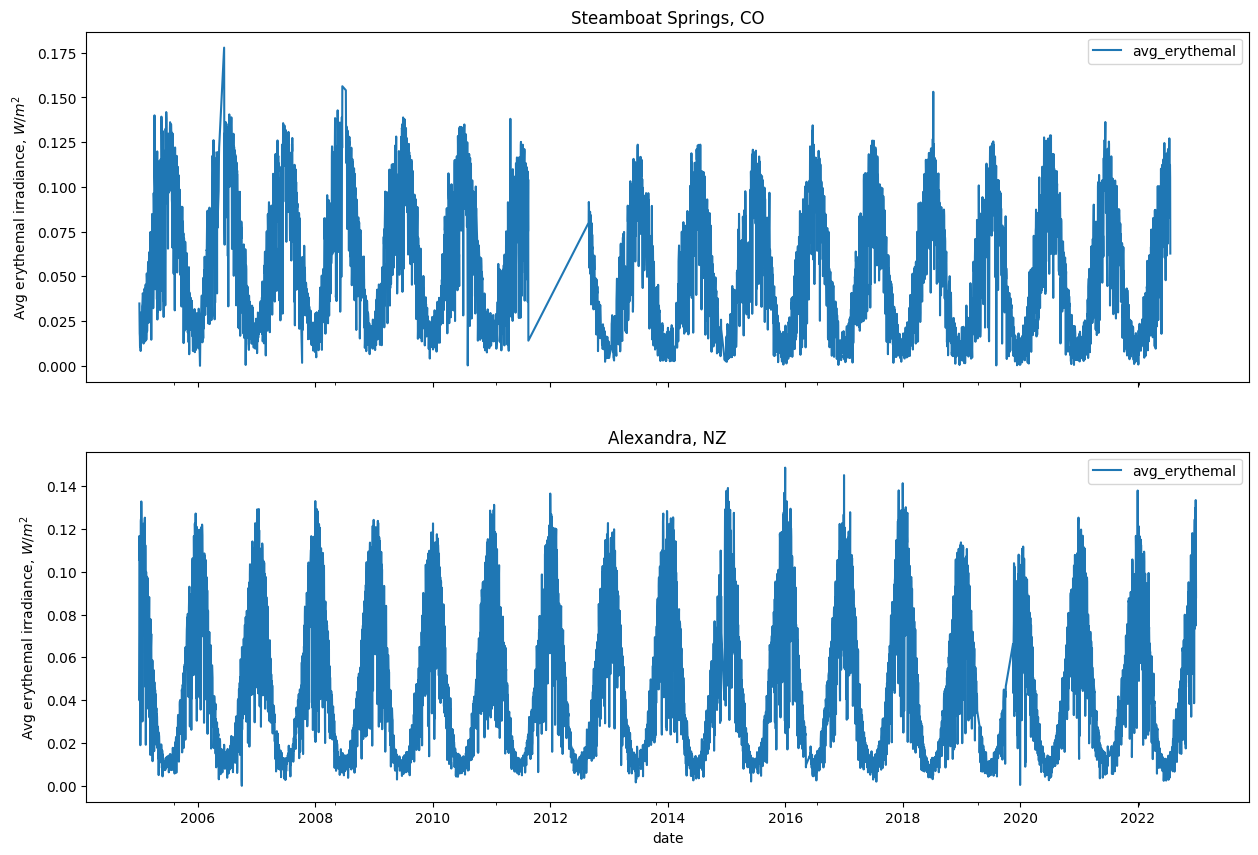

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
df_daily[df_daily["loc_id"] == "CO11"].plot(x="date", y="avg_erythemal", ax=ax[0])
df_daily[df_daily["loc_id"] == "NZ01"].plot(x="date", y="avg_erythemal", ax=ax[1])

ax[0].set_title("Steamboat Springs, CO")
ax[1].set_title("Alexandra, NZ")

ax[0].set_ylabel("Avg erythemal irradiance, $W/m^2$")
ax[1].set_ylabel("Avg erythemal irradiance, $W/m^2$")

In [26]:
ser_co = (
    df_daily.loc[df_daily["loc_id"] == "CO11", ["date", "avg_erythemal"]]
    .set_index("date")
    .squeeze()
)
ser_nz = (
    df_daily.loc[df_daily["loc_id"] == "NZ01", ["date", "avg_erythemal"]]
    .set_index("date")
    .squeeze()
)

# ser_co.plot()

In [24]:
data_CO = (
    df_daily.loc[df_daily["loc_id"] == "CO11", ["date", "avg_erythemal"]]
    .set_index("date")
    .squeeze()
)
data_NZ = (
    df_daily.loc[df_daily["loc_id"] == "NZ01", ["date", "avg_erythemal"]]
    .set_index("date")
    .squeeze()
)

In [25]:
model_CO = DailyAnomalyDetector().fit(data_CO)
preds_CO = model_CO.predict(data_CO)

model_NZ = DailyAnomalyDetector().fit(data_NZ)
preds_NZ = model_NZ.predict(data_NZ)

2023-04-14 06:44:43 INFO     Fitting model to data; dataset size = 5638
2023-04-14 06:44:43 INFO     Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2023-04-14 06:44:43 DEBUG    input tempfile: /var/folders/7s/df87z_717sb1h28b3v6mmcbm0000gq/T/tmp2he9u59y/s0wbk5xd.json
2023-04-14 06:44:43 DEBUG    input tempfile: /var/folders/7s/df87z_717sb1h28b3v6mmcbm0000gq/T/tmp2he9u59y/_77qo__5.json
2023-04-14 06:44:43 DEBUG    idx 0
2023-04-14 06:44:43 DEBUG    running CmdStan, num_threads: None
2023-04-14 06:44:43 DEBUG    CmdStan args: ['/Users/eugenematviychuk/code/uv_monitor/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28141', 'data', 'file=/var/folders/7s/df87z_717sb1h28b3v6mmcbm0000gq/T/tmp2he9u59y/s0wbk5xd.json', 'init=/var/folders/7s/df87z_717sb1h28b3v6mmcbm0000gq/T/tmp2he9u59y/_77qo__5.json', 'output', 'file=/var/folders/7s/df87z_717sb1h28b3v6mmcbm0000gq/T/tmp2he9u59y/prophet_modelgjiuuwqa/prophet_model-202

In [402]:
preds_CO.sample(10)

,y,yhat,yhat_lower,yhat_upper,is_anomaly
ds,,,,,
2010-12-18,0.009836,0.015096,0.000000,0.052470,False
2019-12-18,0.014789,0.007784,0.000000,0.044795,False
2012-10-27,0.027156,0.028403,0.000000,0.064756,False
2021-04-13,0.040194,0.054895,0.016731,0.090595,False
2018-08-02,0.080025,0.086314,0.049039,0.124179,False
2011-06-13,0.088374,0.097950,0.059815,0.135331,False
2014-04-01,0.024032,0.049534,0.011289,0.085378,False
2018-01-24,0.021174,0.013249,0.000000,0.049830,False
2005-06-14,0.132570,0.109863,0.073581,0.147596,False


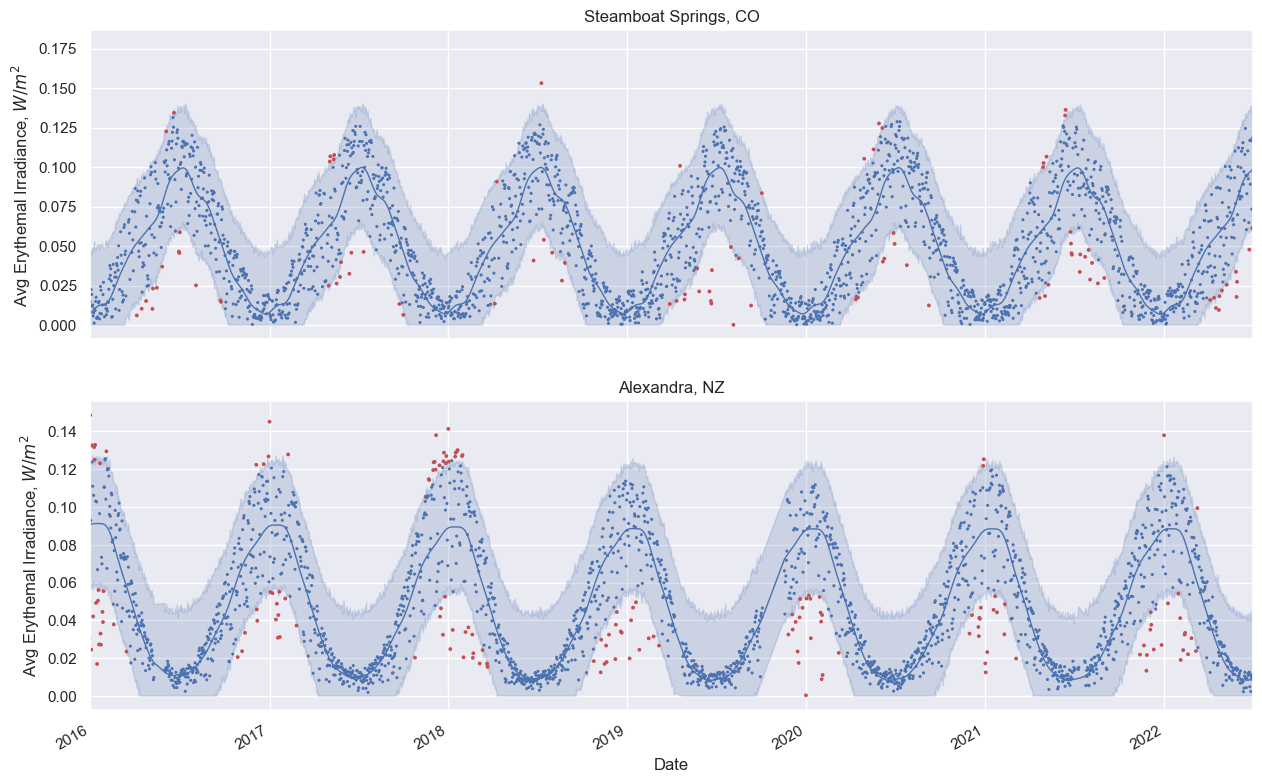

In [403]:
sns.set()

fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

plot_anomaly(
    preds_CO,
    ax[0],
    ("2016-01-01", "2022-07-01"),
    title="Steamboat Springs, CO",
    ylabel="Avg Erythemal Irradiance, $W/m^2$",
)
plot_anomaly(
    preds_NZ,
    ax[1],
    ("2016-01-01", "2022-07-01"),
    title="Alexandra, NZ",
    ylabel="Avg Erythemal Irradiance, $W/m^2$",
)

plt.show()